# CMU 15688 Fall 2019 Final Project: PUBG Analysis


![picture](https://kurdistan24.blob.core.windows.net/filemanager/resources/files/2019/04/PUBG353.jpg)

*picture source: https://www.kurdistan24.net/en/news/fb9905b2-6975-40c4-b15a-40bf4bda4c2e*

## Table of Content
1. Introduction
2. Project Pipeline
3. Data Introduction
4. Data Preporcessing
5. Preliminary Analysis for Winning Strategy
6. Predictive Modeling for Winning Place
7. Player Clustering
8. Outlier Detection to Detect Illegal Matches/Cheaters/Zombies
9. Anomely Detection
10. Conlusion
11. APPENDIX

## Introduction
PlayerUnknown's Battlegrounds (PUBG) is a Battle Royale-style video game that became popular over the past few years. The game is desinged with 100 players dropped onto an island empty-handed and players need to figure out how to explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.

The goal of this data science project is two-folded for both players and developers. Players could leverage the insights from this project to get a better winning strategy, while developers could better understand the common strategies taken by groups of players to segment players, and also find out ways to detect cheaters and zombies to improve the game. 


## Project Pipeline
![pubg-pipeline.jpg](https://github.com/surancy/pubg-prediction/blob/master/pubg-pipeline.jpg?raw=true)

After the data was scrapped from PUBG api and preprocessed, the preliminary analysis was ran for exploring correlation among variables and detect outliers. Both supervised and unsupervised machine learning models were used here, with the supervised learning to predict the player's winning place, and the unsupervised learning to segment players. The final evaluation was to find out insights after machine learning models were built, and provide actionable recommendations for both developers and gamers.


## Data Introduction


Data was scrapped from PUBG api, collected from three platforms, steam, PS4/Xbox, kakao. Total 173,000 players from 2007 matches are scrapped, covering 3 types of game mode: duo, solo, squad. Statistics of players are also scrapped in each match, including kills, kills streaks, heals, assists, weapons acquired, walking distance, vehicle destroyed, and winning place of this game.  

The scrapper code is included in the *APPENDIX B: scrapper*. For the detailed notation of each variable, please see *APPENDIX B continued: Data Introduction*.


In [0]:
# data.csv from scrapper as included in APPENDIX B
# any block of code in this report must have run the library import from APPENDIX A first
data = pd.read_csv('data.csv')
data.shape, data.columns

((173087, 23),
 Index(['playerId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
        'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks',
        'longestKill', 'matchDuration', 'matchType', 'revives', 'rideDistance',
        'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
        'walkDistance', 'weaponsAcquired', 'winPlace'],
       dtype='object'))

## Preliminary Analysis for Winning Strategy
Let's conduct preliminary analysis through EDA for winning strategy to gain a better understanding of the game.


### Transfrom winPlace to winPlace percentage
Notice that the dataset include variable "winPlace" which represent players final rank in a match. Usually, there are 100 players participate in one match. However, due to connect issue, sometime times one match has less than 100 players. To confirm this idea, we first visualize the number of players per game.

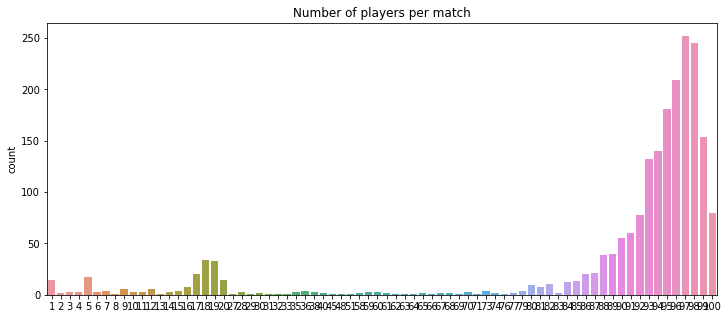

In [0]:
num_players_match = data.groupby(data['matchId'])['playerId'].count().tolist()
plt.figure(figsize = (12,5))
sns.countplot(num_players_match).set_title('Number of players per match')
plt.show()

Not all matches has 100 players. Thus, we need to create percentage of winPlace, where 1 corresponds to 1st place, and 0 represent the last place. Similarily, the variable "killPlace" need the same transformation

In [0]:
data['winPlacePerc'] = data.groupby(data['matchId'])['winPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
data = data.drop(columns=['winPlace'])
data['winPlacePerc'].fillna(0,inplace = True)

In [0]:
data['killPlacePerc'] = data.groupby(data['matchId'])['killPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
data = data.drop(columns=['killPlace'])
data['killPlacePerc'].fillna(0,inplace = True)

### Player behavior and win place
#### Kills & weapon require
Most people has the impression that PUBG is a game about killing other palyers. Therefore, most of new players focus on improving their skills on finding weapon and killing. First, let's have a look at how players performed in terms of killing.


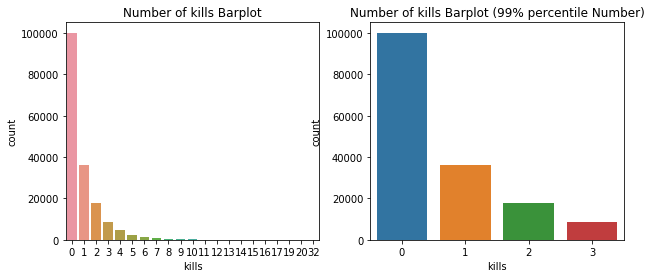

number of kills 50% percentile is: 0.0
number of kills 75% percentile is: 1.0
number of kills 90% percentile is: 3.0
number of kills 95% percentile is: 4.0
number of kills 99% percentile is: 7.0


In [0]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,4))
sns.countplot(data['kills'],ax = ax[0]).set_title('Number of kills Barplot')
sns.countplot(data[data['kills'] < data['kills'].quantile(0.95)]['kills'],
              ax=ax[1]).set_title('Number of kills Barplot (99% percentile Number)')
plt.show()
print('number of kills 50% percentile is: ' + str(data['kills'].quantile(0.5)))
print('number of kills 75% percentile is: ' + str(data['kills'].quantile(0.75)))
print('number of kills 90% percentile is: ' + str(data['kills'].quantile(0.9)))
print('number of kills 95% percentile is: ' + str(data['kills'].quantile(0.95)))
print('number of kills 99% percentile is: ' + str(data['kills'].quantile(0.99)))

Over 50% of players never made a kills for the entire match and 99% players successfully killed less than 4 other players. It looks like **the number of kills needed to complete in a match is not as large as we expected.**

Then, our next question is: how's the relationship between kills and win place?

In [0]:
data.loc[data['matchType'] == 'duo','matchType_combine'] = 'duo'
data.loc[data['matchType'] == 'duo-fpp','matchType_combine'] = 'duo'
data.loc[data['matchType'] == 'solo','matchType_combine'] = 'solo'
data.loc[data['matchType'] == 'solo-fpp','matchType_combine'] = 'solo'
data.loc[data['matchType'] == 'squad','matchType_combine'] = 'squad'
data.loc[data['matchType'] == 'squad-fpp','matchType_combine'] = 'squad'

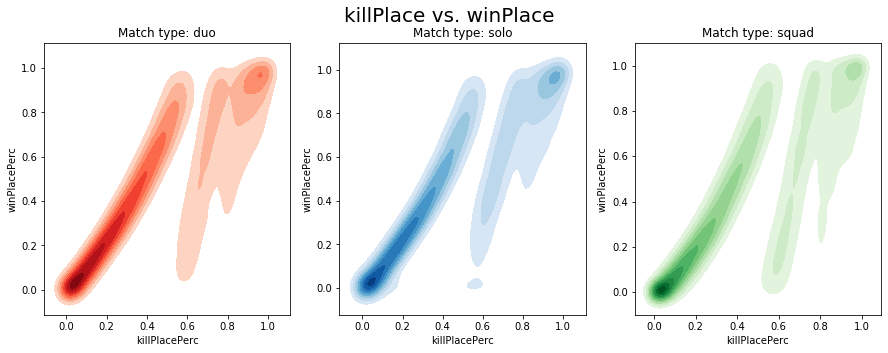

In [0]:
f,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))

sns.kdeplot(data.loc[(data['matchType']=='duo')|(data['matchType']=='duo-fpp')]['killPlacePerc'],
                      data.loc[(data['matchType']=='duo')|(data['matchType']=='duo-fpp')]['winPlacePerc'],
                      cmap='Reds', shade=True,shade_lowest=False,ax=ax[0]).set_title('Match type: duo')

sns.kdeplot(data.loc[(data['matchType']=='solo')|(data['matchType']=='solo-fpp')]['killPlacePerc'],
                      data.loc[(data['matchType']=='solo')|(data['matchType']=='solo-fpp')]['winPlacePerc'],
                      cmap='Blues', shade=True,shade_lowest=False,ax=ax[1]).set_title('Match type: solo')

sns.kdeplot(data.loc[(data['matchType']=='squad')|(data['matchType']=='squad-fpp')]['killPlacePerc'],
                      data.loc[(data['matchType']=='squad')|(data['matchType']=='squad-fpp')]['winPlacePerc'],
                      cmap='Greens', shade=True,shade_lowest=False,ax=ax[2]).set_title('Match type: squad')

plt.suptitle('killPlace vs. winPlace',fontsize=20)
plt.show()

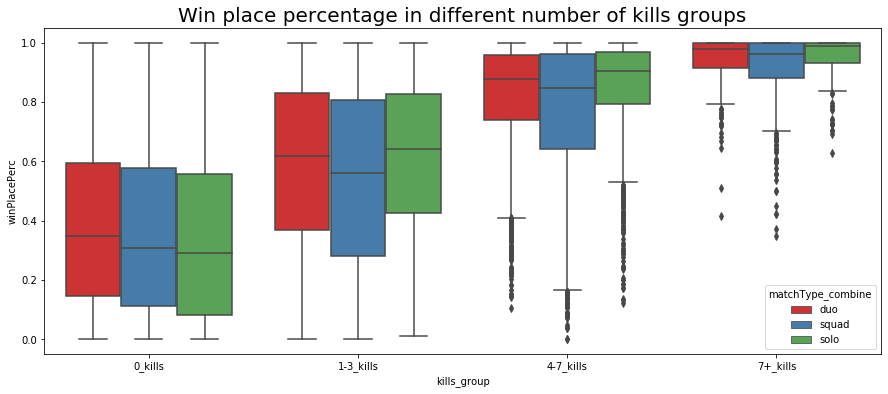

In [0]:
data['kills_group'] = pd.cut(data['kills'], [-1, 0, 3, 7, 40], labels=['0_kills','1-3_kills', '4-7_kills', '7+_kills'])
plt.figure(figsize=(15,6))
sns.boxplot(x=data["kills_group"], y=data["winPlacePerc"],hue=data['matchType_combine'],
           palette=sns.color_palette("Set1"))
plt.title('Win place percentage in different number of kills groups', fontsize=20)
plt.show()

In [0]:
df = data[['kills','winPlacePerc']]
df.corr(method='pearson')

,kills,winPlacePerc
kills,1.000000,0.430347
winPlacePerc,0.430347,1.000000


**The number of kills and win place has a positive correlation.** In other word, improving your killing skills can increase the propobility of winning. However, it's clear that killing more not equal to win.

Another feature highly correalted with killing is weapon. A lot of players are eager to keep search for the best weapon because they believe acuqiring a great weanpon can help them win. Is that true?

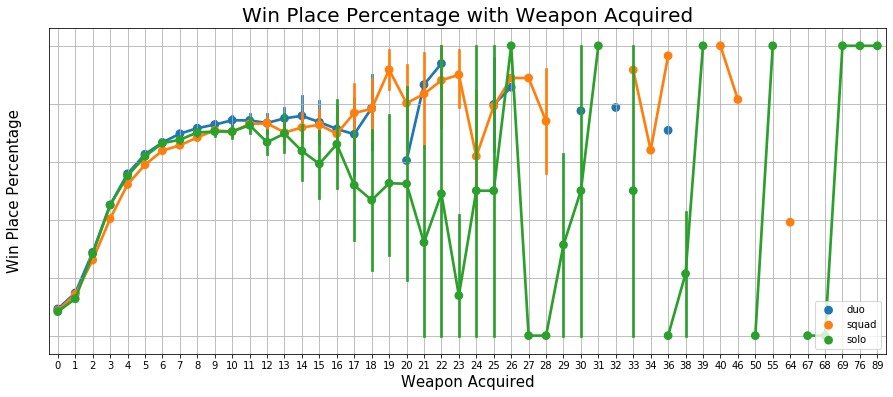

number of weapons 25% percentile is: 2.0
number of weapons 50% percentile is: 4.0
number of weapons 75% percentile is: 5.0
number of weapons 90% percentile is: 7.0
number of weapons 99% percentile is: 11.0


In [0]:
f,ax = plt.subplots(figsize =(15,6))
ax.set_xlabel(xlabel='Kill Place')
ax.tick_params(axis='x')
ax.set_ylabel(ylabel='Win Place Precentage')
ax.tick_params(axis='y', colors='white')
sns.pointplot(x=data['weaponsAcquired'],y=data['winPlacePerc'], hue=data['matchType_combine'],
              alpha=0.8)
plt.xlabel('Weapon Acquired',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Weapon Acquired',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()
print('number of weapons 25% percentile is: ' + str(data['weaponsAcquired'].quantile(0.25)))
print('number of weapons 50% percentile is: ' + str(data['weaponsAcquired'].quantile(0.50)))
print('number of weapons 75% percentile is: ' + str(data['weaponsAcquired'].quantile(0.75)))
print('number of weapons 90% percentile is: ' + str(data['weaponsAcquired'].quantile(0.90)))
print('number of weapons 99% percentile is: ' + str(data['weaponsAcquired'].quantile(0.99)))

Since 99% of people acquired less than 11 weapons during one match, if you're a common player, **finding more weapons would increase your ranking**. However, **after finding 6 weapons, the power that weapons can bring not significant any more**. You might need to focus on other strategy then.

#### Transportation
As number of players decreasing, the chance that palyers can meet each other decreases. To speed up the game and make the game more interesting, the game use the play zone, or circle, mechanism. The circle is a large field that continually shrinks the designated play area. Therefore, proper transportation tool plays an important role in the game. The most common transportation tool is vehicle.

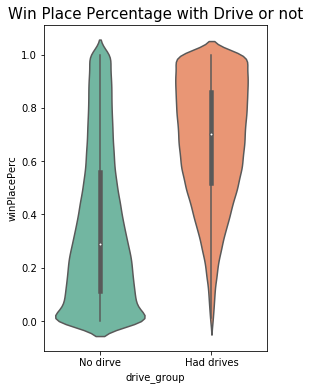

In [0]:
data['drive_group'] = pd.cut(data['rideDistance'], [-1, 0, 50000], labels=['No dirve','Had drives'])

fig,ax = plt.subplots(figsize =(4,6))
ax.tick_params(axis='x')
ax.set_ylabel(ylabel='Win Place Precentage')
ax.tick_params(axis='y')

sns.violinplot(x=data["drive_group"], y=data["winPlacePerc"],palette=sns.color_palette("Set2"))
plt.title('Win Place Percentage with Drive or not', fontsize=15)
plt.show()

data = data.drop(['drive_group'],axis=1)

Clearly, players who drove has a high propobility of winning than players who never found a car. Thus, players should also focus on **finding a car** to improve their chance to win.

In PUBG, some players prefer to destroy the vehicle before they leave to avoid others can use it. Let's have a look at how this behavior affect win.

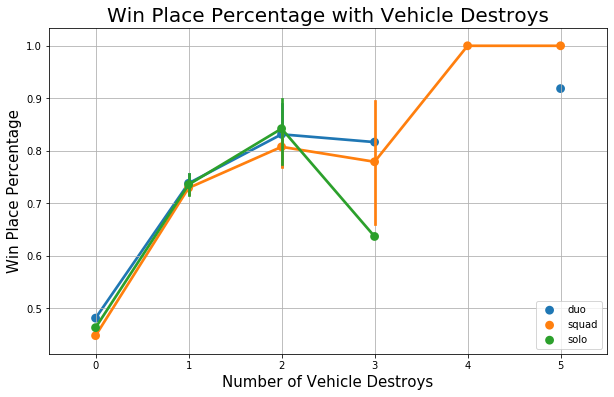

In [0]:
f,ax = plt.subplots(figsize =(10,6))
sns.pointplot(x=data['vehicleDestroys'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Vehicle Destroys',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

Destroying vehicle can improve wining probablity. However, considering the fact that usually only experienced players have this behavior, the improvement of winning chance might just caused by these players advanced skills.

#### Item usage
In PUBG, players life is measured by percentage of health. When player reaches 0% health, the character will die. To extend life, player can use healling items to increase health at once, or using boosting items to increase health graudally and improve the speed of movement at the same time. Will this behavior affect win place?

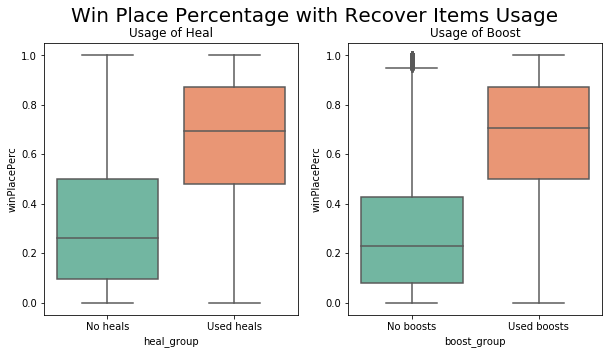

In [0]:
data['heal_group'] = pd.cut(data['heals'], [-1, 0, 50000], labels=['No heals','Used heals'])
data['boost_group'] = pd.cut(data['boosts'], [-1, 0, 50000], labels=['No boosts','Used boosts'])

f,ax = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
sns.boxplot(x=data["heal_group"], y=data["winPlacePerc"],palette=sns.color_palette("Set2"),ax=ax[0]).set_title('Usage of Heal')
sns.boxplot(x=data["boost_group"], y=data["winPlacePerc"],palette=sns.color_palette("Set2"),ax=ax[1]).set_title('Usage of Boost')
plt.suptitle('Win Place Percentage with Recover Items Usage', fontsize=20)
plt.show()

Using healing or boosting items can significantly improve players win place. Then, next question come into our mind: how many healing and boosting items should I use?

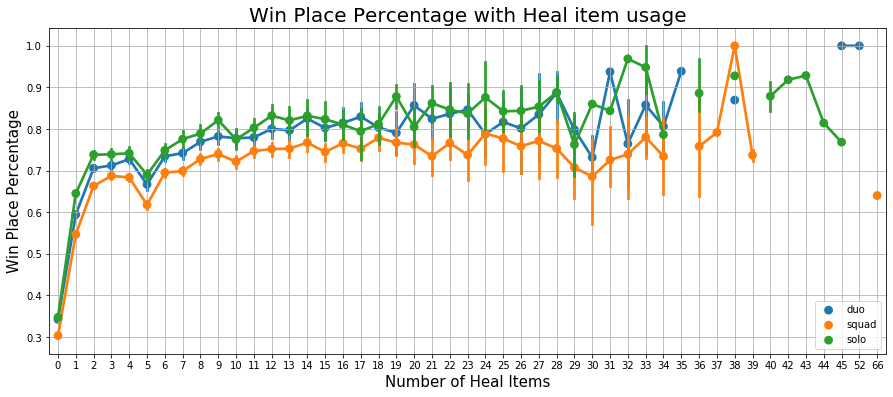

In [0]:
f,ax1 = plt.subplots(figsize =(15,6))
sns.pointplot(x=data['heals'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Heal Items',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Healing item usage',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

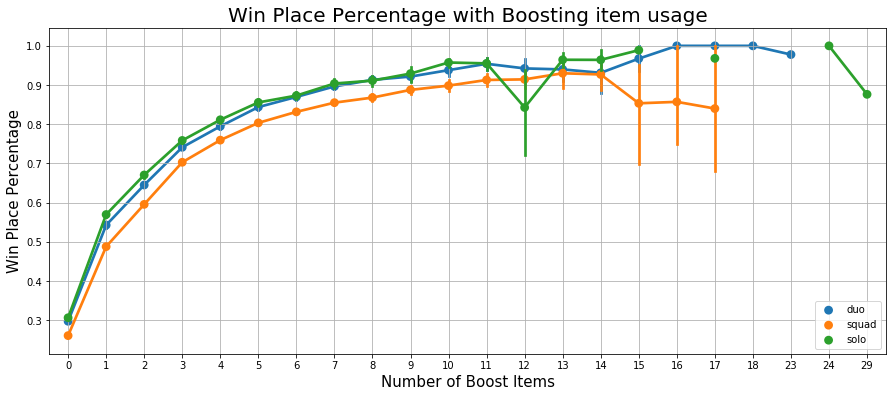

In [0]:
f,ax1 = plt.subplots(figsize =(15,6))
sns.pointplot(x=data['boosts'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Boost Items',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Boosting item usage',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

After players used 2 healing items, the effect of healing on improving win place on longer significant any more. However, using more and more boosting items keep increase player chance to win. Therefore, **if a player found a package contains healing items, keeping 2 is enough. But for boosting items, storing them and using them contiously might be a smart action.**

#### Teamwork
Recently, several organization formed to help players to find teammates to join a match easily. Will the teamwork help you win?

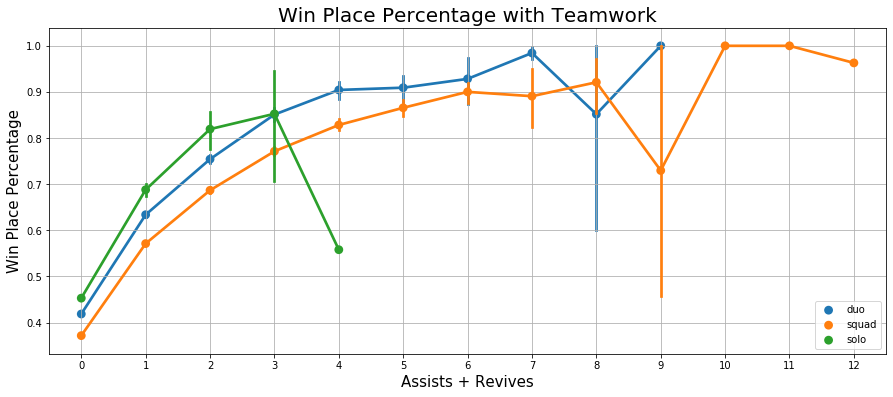

In [0]:
data['teamwork'] = data['assists']+data['revives']
f,ax = plt.subplots(figsize =(15,6))

sns.pointplot(x=data['teamwork'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Assists + Revives',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Teamwork',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

data = data.drop(['teamwork'],axis = 1)

It looks like teamwork did improve the chance of winning.

In summary, the winning strategy looks like this:
1. Try to kill other players. However, don't be obssessed with finding advanced weapon and killing more people.
2. Try you best to find a transportation tools. Before you leave your vehicle, remember to destroy it.
3. Keep as many as possible boosting items in your bag and use them contiously. For healing items, storing 2 is enough. 
4. If possible, find a good teammates.

This wining strategy is pretty rough. Although we have a idea about what factors might improve our performance, we don't know which one plays the decisive role for winning. To slove this problem, let's build a tree-based predictive model and explore the feature importance.

## Preditive Model
Here we will use the LightGBM model in this case. LightGBM's high performance in many tasks, high effeciency and parallel learning support make it popular in recent years.

### Feature engineering
From the DEA above, we have a rough idea about what variables might contribute the players final ranking. In general, winPlace heavily rely on **usage of items, transportation and weapons** in a match. Therefore, we can generate some useful features around them.

In [0]:
# total items used
data['item'] = data['heals']+data['boosts']
# total distance
data['distance'] = data['walkDistance'] + data['rideDistance']+data['swimDistance']
# Since healing and boosting items both can help players to move and thus stay out of the circle, we create some features to capture relationship between them
data['walkDistance_heals'] = data['walkDistance']/(data['heals']+1) # to avoid inifity
data['walkDistance_boosts'] = data['walkDistance']/(data['boosts']+1)
# weapon
data['weapon_kills'] = data['weaponsAcquired']/(data['kills']+1)
# teamwork
data['teamwork'] = data['assists']+data['revives']


In [0]:
# drop features created for EDA
data = data.drop(['matchType_combine', 'kills_group', 'heal_group','boost_group'],axis=1)

### Data preprocessing 
To apply the LGB model, we need to transform variable types to float/int.

In [0]:
def transfrom_data(column):
    le = LabelEncoder()
    le.fit(list(data[col]))
    data[col] = le.transform(data[col])
    return data

In [0]:
def random_sample(data, num_match):
    match_ids = data['matchId'].unique().tolist()
    random_matches = random.sample(match_ids, num_match)
    sample_data = data.loc[data['matchId'].isin(random_matches)]
    return sample_data

In [0]:
# we need to split train and test sets by match
def split_data(data, split_percent = 0.2):
    match_ids = data['matchId'].unique().tolist()
    train_matches = random.sample(match_ids, int(len(match_ids)*(1-split_percent)))
    
    train = data.loc[data['matchId'].isin(train_matches)]
    test = data.loc[~data['matchId'].isin(train_matches)]
    
    return train, test

### Modeling

In [0]:
class LGB():
    def __init__(self, train, test, num_cv, parameter):
        train = train.drop(columns=['playerId','matchId','matchDuration'])
        test = test.drop(columns=['playerId','matchId','matchDuration'])
        self.train = train
        self.test = test
        self.num_cv = num_cv
        self.parameter = parameter
    
    def split(self):
        self.train_y = self.train['winPlacePerc']
        self.train_x = self.train.drop(['winPlacePerc'],axis=1)
        self.test_y = self.test['winPlacePerc']
        self.test_x = self.test.drop(['winPlacePerc'],axis=1)
        
    def cross_validation(self):
        folds = KFold(n_splits=self.num_cv, shuffle=True, random_state=1234)
        columns = self.train_x.columns
        self.splits = folds.split(self.train_x, self.train_y)
    
    def training(self):
        self.split()
        self.cross_validation()
        
        y_pred_test_vectors = np.zeros(self.test_x.shape[0])
        y_pred_valid_vectors = np.zeros(self.train_y.shape[0])
        
        train_mse = 0
        valid_mse = 0

        feature_importances = pd.DataFrame()
        feature_importances['feature'] = train_x.columns
        
        for fold_n, (train_index, valid_index) in enumerate(self.splits):
            x_train = self.train_x.iloc[train_index] 
            x_valid = self.train_x.iloc[valid_index]
            y_train = self.train_y.iloc[train_index] 
            y_valid = self.train_y.iloc[valid_index]
            
            dtrain = lgb.Dataset(x_train, label=y_train)
            dvalid = lgb.Dataset(x_valid, label=y_valid)

            model = lgb.train(self.parameter, dtrain, 10000, valid_sets = [dtrain, dvalid],verbose_eval=False)

            # Record feature importance
            feature_importances['fold_{}'.format(fold_n + 1)] = model.feature_importance()

            # Predict and put OOF predicted data into holdout position
            y_pred_train = model.predict(x_train)
            y_pred_valid = model.predict(x_valid)
            y_pred_valid_vectors[valid_index] = y_pred_valid

            # Averaging mse
            train_mse += mean_squared_error(y_train, y_pred_train) / self.num_cv
            valid_mse += mean_squared_error(y_valid, y_pred_valid) / self.num_cv

            # Averaging predicting value
            y_pred_test_vectors += model.predict(self.test_x) / self.num_cv

            del x_train, x_valid, y_train, y_valid

            #gabage collector
            gc.collect()
        return model, train_mse, valid_mse, y_pred_test_vectors, feature_importances

To avoid overfitting, using different numbers of samples for training and validation and visualize the result.

In [0]:
params = {
                    'objective':'regression',
                    'boosting_type':'gbdt',#traditional Gradient Boosting Decision Tree, aliases:
                    'metric':'rmse',
                    'learning_rate':0.005,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'early_stopping_rounds':250,
                    'seed': 1234,
                } 

In [0]:
match_nums = [100*i for i in range(1,20)] + [2007]

In [0]:
# This process takes long time, we run this cell on AWS to get the plot. We saved the mse for training and validation and load them directly in this notebook.
%%time
train_mse_lst = []
valid_mse_lst = []
y_pred_test = []
for num in match_nums:
    start_time = time.time()
    dataset = random_sample(data,num)
    train_set, test_set = split_data(dataset)
    model_lgb = LGB(train_set, test_set, 5, params)
    model, train_mse, valid_mse, y_pred_test_vectors, fe = model_lgb.training()
    train_mse_lst.append(train_mse)
    valid_mse_lst.append(valid_mse)
    y_pred_test.append(y_pred_test_vectors)
    print('Finish training for number of samples: ' + str(num))
    print('time used {}'.format(time.time()-start_time))
    print('-'*20)

In [0]:
train_mse = np.load('train_mse.npy')
valid_mse = np.load('valid_mse.npy')

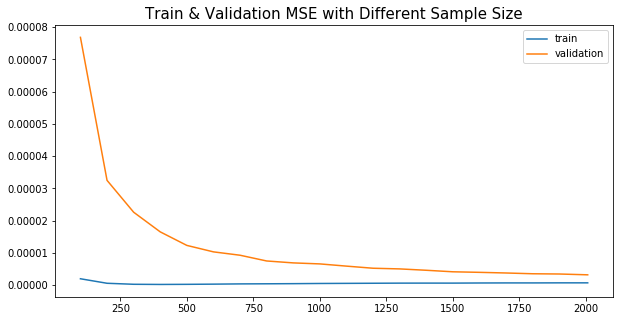

In [5]:

f,ax = plt.subplots(figsize =(10,5))
sns.lineplot(x=match_nums,y = train_mse, label='train')
sns.lineplot(x=match_nums,y = valid_mse, label = 'validation')
plt.title('Train & Validation MSE with Different Sample Size', fontsize=15)
plt.show()

The training error and validation error converged in the end. Our model didn't overfit. Now, let's look at the feature importance of our final model>

Notes: The process of training takes long time to run (about 1.5 hour for the final moal). To save your time, we saved the feature importance and load it directly.

In [0]:
fe = pd.read_csv('feature_importance.csv')

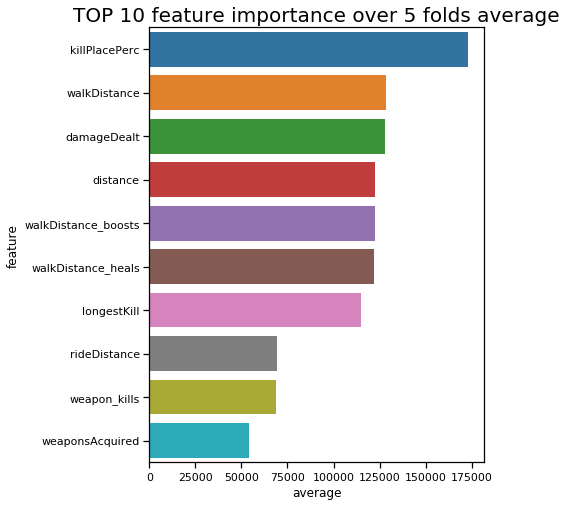

In [0]:
fe['average'] = fe.mean(axis = 1)
plt.figure(figsize=(6, 8))
sns.barplot(data=fe.sort_values(by='average', ascending=False).head(10), 
            x='average', y='feature').set_title('TOP 10 feature importance over 5 folds average', fontsize=20)
sns.set_context("notebook",rc={"lines.linewidth": 2.5})
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

From the above plot we find out that **kills, move distance, and damage** play importance role in players performance.

Now we have a clear mind about how to improve our performance in PUBG. However, as a common player, we cannot beat cheaters who use game plugin. There is a rumor that there are many cheaters in PUBG. Is that true? We will use the anomaly detection method we learned from the course the check that.

## Outlier Detection
Outlier detection on match and player level. The purpose is to detect potential illegal matches and cheaters/zombies of the game.

### Illegal Matches?
At the match level, there are 10 games out of 170k examples with abnormal length of match duration. There are no games with no players joined.

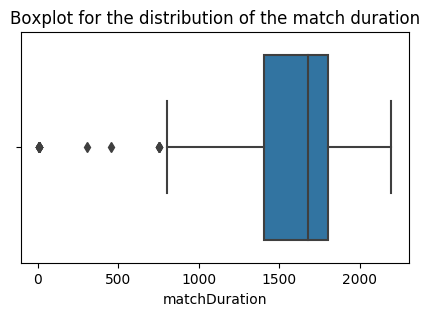

In [0]:
# plot boxplot for match duration
plt.style.use('default')
plt.figure(figsize = (5,3))
sns.boxplot(data.matchDuration)
plt.title("Boxplot for the distribution of the match duration")
plt.show()

In [0]:
# check for the games under normal length of duration
display(len(data[(data['matchDuration'] < 500)]['matchDuration']))
display(data[(data['matchDuration'] < 500)]['matchDuration'])

# delete those data with match duratino shorter than 10 seconds
data = data.drop(index = data[(data['matchDuration'] < 10)].index).reset_index().drop(columns = ['index'])

12

87149     456
91096       8
96030       8
96187     309
99417       8
102400      8
110025      8
118365      8
118366      8
118367      8
127609      8
135300      8
Name: matchDuration, dtype: int64

There are some outliers in the match duration. With the median around 1600s and some matches only last for 8 seconds, we suspect some of the matches go wrong that could either caused by loading error or bug. 

In [0]:
# check if exist illegal match where no players joined
data[(data.groupby("matchId")['playerId'].transform(len) == 0)]

,playerId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlace


The proportion of illegal matches with no players joined was relatively smaller than the matches with abnormal lasting time.

### Cheaters?

After the outlier detection at match level, we detect ouliers on player level. To detect potential cheaters and zombies from players, several features added to the original dataset to come up with more meaningful conclusions (*see APPENDIX C: Feature Engineering for Outlier Detection*).   
Here are the findings for cheaters and zombies, respectively.

In [0]:
# data with new features added
data = outlierFeatureEngineering(data)

Cheaters are those who use some third-party softwares to enhance their statistics in the game. Most cheaters choose those software that could help them boost the killing statistics. So the features used to detect cheaters are mostly related with killing statistics.

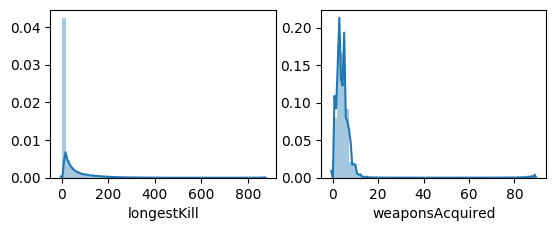

148


In [0]:
# check outliers of the longest kill
plt.style.use('default')
ax1 = plt.subplot(221)
ax1 = sns.distplot(data['longestKill'])
ax2 = plt.subplot(222)
ax2 = sns.distplot(data.weaponsAcquired)
plt.show()


# how many outliers detected
print(data[(data.longestKill > 400)].shape[0] + data[(data.weaponsAcquired > 50)].shape[0])

# drop outliers
data = data.drop(data[(data.longestKill > 400)].index)
data = data.drop(data[(data.weaponsAcquired > 50)].index)

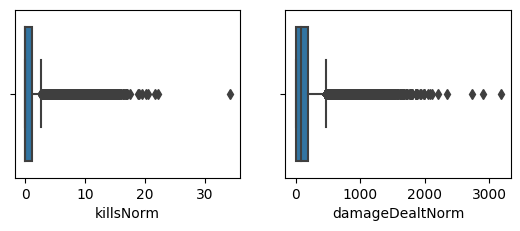

(33, 21)
(73, 21)


In [0]:
# check players with abnormal kills in one match
ax1 = plt.subplot(221)
ax1 = sns.boxplot(data['killsNorm'])

ax2 = plt.subplot(222)
ax2 = sns.boxplot(data['damageDealtNorm'])

plt.show()
print(data[(data['killsNorm'] > 15)].shape)
print(data[(data['damageDealtNorm'] > 1500)].shape)

In [0]:
# remove outliers with too many kills and damage dealt
data = data.drop(data[(data['killsNorm'] > 15)].index)
data = data.drop(data[(data['damageDealtNorm'] > 1500)].index)

The number of kills and damage dealt themselves could not best indicate whether a player is a cheater or not. Although high kills and high damage dealt surely are outliers, they could also be players with really great killing statistics. To locate cheaters, we need to combine more features.
Some features that could better locate cheaters are, players who kill without moving, and players who kill significant amount but have a headshot rate of 100%.

(7, 21)

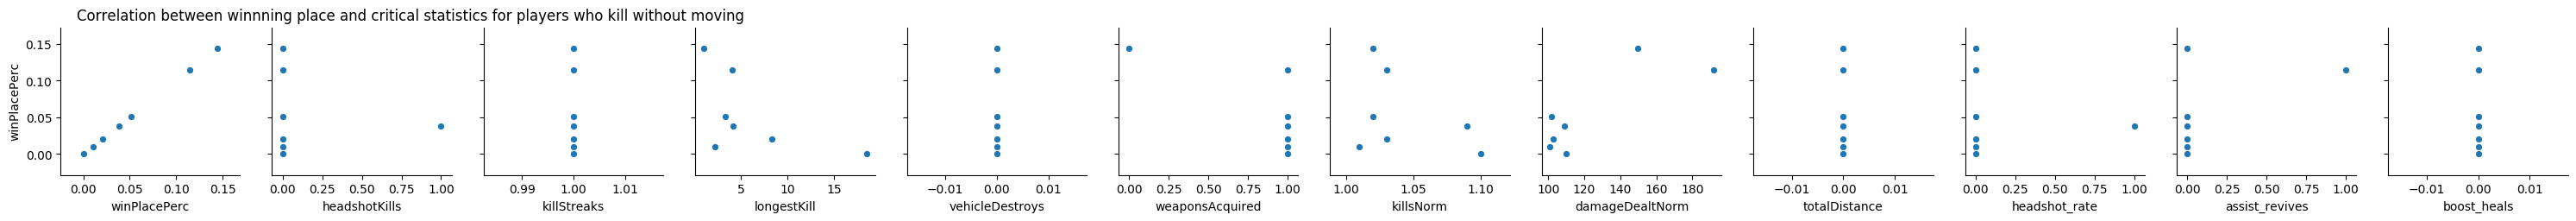

In [0]:
# check players who kills without moving
display(data[(data['killsNorm'] > 0) & (data['totalDistance'] == 0)].shape)

sns.pairplot(x_vars = ['winPlacePerc','headshotKills', 'killStreaks', 'longestKill','vehicleDestroys',
                       'weaponsAcquired','killsNorm','damageDealtNorm',
                       'totalDistance', 'headshot_rate', 'assist_revives', 'boost_heals'],
             y_vars = 'winPlacePerc', data = data[(data['killsNorm'] > 0) & (data['totalDistance'] == 0)])
plt.title("Correlation between winnning place and critical statistics for players who kill without moving", x = -11)
plt.tight_layout()
plt.show()

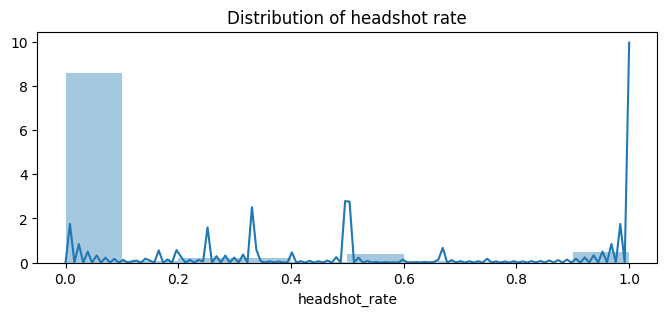

In [0]:
# Plot the distribution of headshot rate
plt.figure(figsize=(8,3))
sns.distplot(data['headshot_rate'], bins=10)
plt.title("Distribution of headshot rate")
plt.show()

In [0]:
# Players who made a minimum of 5 kills and have a headshot_rate of 100%
display(data[(data['headshot_rate'] >= 1.0) & (data['killsNorm'] >= 5)].shape)
data[(data['headshot_rate'] >= 1.0) & (data['killsNorm'] >= 5)].iloc[:,2:]

(6, 21)

,headshotKills,killStreaks,longestKill,matchDuration,matchType,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,playersJoined,winPlacePerc,killsNorm,damageDealtNorm,totalDistance,headshot_rate,assist_revives,boost_heals
5810,5,5,1.294081,1795,squad,0.0000,0,0.00000,0,811.4638,4,94,0.166667,5.30,530.000000,811.46380,1.0,0,0
8606,5,2,111.846954,1345,squad,0.0000,0,0.00000,0,3891.8857,3,96,0.916667,5.20,812.769204,3891.88570,1.0,1,8
29354,6,2,123.928280,1599,squad,1317.5952,0,0.00000,0,3327.7390,5,92,1.000000,6.48,1035.612292,4645.33420,1.0,2,17
48038,4,4,3.478153,1717,squad,3090.4172,0,68.75996,0,1440.1127,4,65,0.315789,5.40,540.000000,4599.28986,1.0,0,2
108916,6,2,152.975810,1744,solo,0.0000,0,0.00000,0,4258.8850,5,98,0.867347,6.12,478.152438,4258.88500,1.0,0,1
141967,6,6,6.176190,1891,squad,0.0000,0,209.33230,0,3876.2612,5,98,0.655172,6.12,819.583362,4085.59350,1.0,0,0


In [0]:
# who are these cheaters
df_cheaters = data[((data['killsNorm'] > 0) & (data['totalDistance'] == 0)) | ((data['headshot_rate'] >= 1.0) & (data['killsNorm'] >= 5))]
df_cheaters.shape

cheaters_kills = df_cheaters.killsNorm
cheaters_damage = df_cheaters.damageDealtNorm
cheaters_win = df_cheaters.winPlacePerc

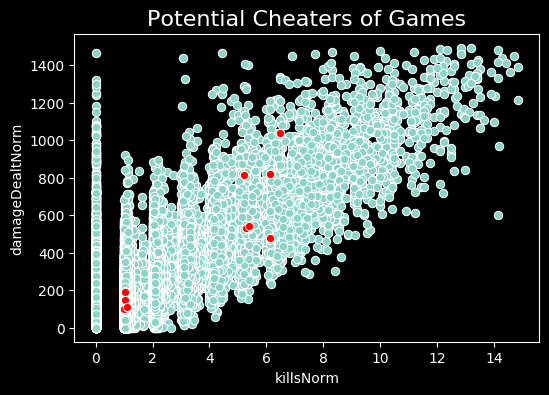

In [0]:
# plot the cheaters using killing statistics
plt.style.use('dark_background')
plt.figure(figsize = (6,4))
sns.scatterplot(data.killsNorm, data.damageDealtNorm)
sns.scatterplot(cheaters_kills,cheaters_damage, color= 'red')
plt.title("Potential Cheaters of Games", fontsize = 16)
plt.show()

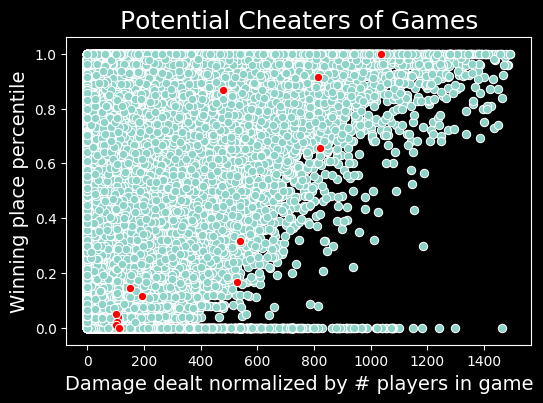

In [0]:
# plot cheaters with their correlation to winnning percentile
plt.figure(figsize = (6,4))
sns.scatterplot(data.damageDealtNorm, data.winPlacePerc)
sns.scatterplot(cheaters_damage,cheaters_win, color= 'red')
plt.ylabel("Winning place percentile", fontsize = 14)
plt.xlabel("Damage dealt normalized by # players in game", fontsize = 14)
plt.title("Potential Cheaters of Games",fontsize = 18)
plt.show()

From the graph, not all cheaters have good winning place, some have, some don’t. 

In [0]:
# drop potential cheaters
data = data.drop(df_cheaters.index)
print("{} potential cheaters detected and removed".format(df_cheaters.shape[0]))

13 potential cheaters detected and removed


### Zombies?
Zombies are those who freeze because of the network error or problems in player account. So the features used to detect zombies are related with their moving distance. There are around 10k zombies detected out of the 170k samples.

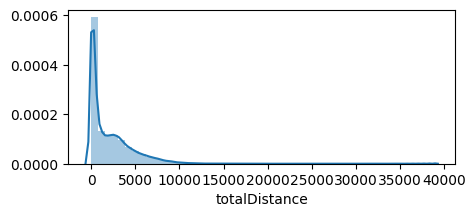

In [0]:
# check moving distance
plt.style.use('default')
plt.figure(figsize = (5,2))
sns.distplot(data.totalDistance)
plt.show()

In [0]:
# check those players who do not move at all
print("{} players do no move at all".format(data[(data.totalDistance == 0)].shape[0]))

5905 players do no move at all


In [0]:
# check those players who have no resource collected and move distance smaller than 20
print("{} players have no resource collected with moving distance smaller than 10".format(data[(data.boost_heals == 0) & (data.totalDistance <= 10)].shape[0]))


8028 players have no resource collected with moving distance smaller than 10


In [0]:
# check players have no kills, no weapons collected, and no heals and boosts
print("{} players have no kills, no weapons collected, no heals and boosts, and zero total moving distance".format(data[(data.boost_heals == 0) & (data.killsNorm == 0) & (data.weaponsAcquired == 0) & (data.totalDistance == 0)].shape[0]))


3419 players have no kills, no weapons collected, no heals and boosts, and zero total moving distance


In [0]:
# who are these zombies
df_zombies = data[(data.totalDistance == 0) | ((data.boost_heals == 0) & (data.totalDistance <= 20)) | ((data.boost_heals == 0) & (data.killsNorm == 0) & (data.weaponsAcquired == 0) & (data.totalDistance == 0))]

In [0]:
print("{} total potential zombies detected".format(df_zombies.shape[0]))
zombies_kill = df_zombies.killsNorm
zombies_damage = df_zombies.damageDealtNorm
zombies_win = df_zombies.winPlacePerc

10830 total potential zombies detected


Text(0.5, 1.0, 'Potential Zombies of Games')

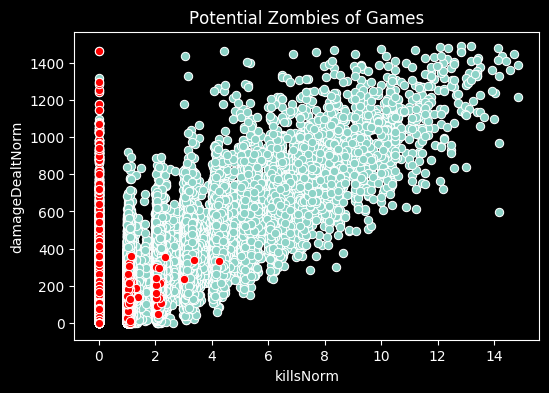

In [0]:
# plot zombies with regards to killing statistics
plt.style.use('dark_background')
plt.figure(figsize = (6,4))
sns.scatterplot(data.killsNorm, data.damageDealtNorm)
sns.scatterplot(zombies_kill,zombies_damage, color= 'red')
plt.title("Potential Zombies of Games")


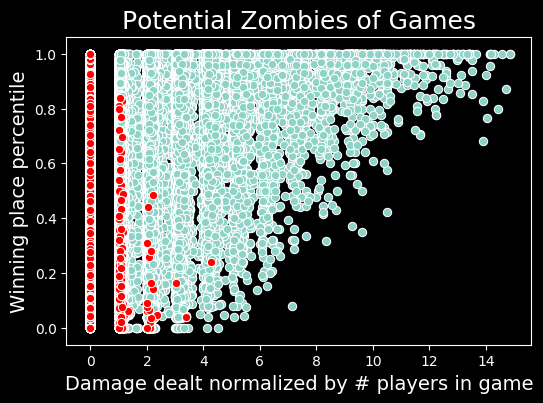

In [0]:
# plot zombies with regards to the correlation to the winning place
plt.figure(figsize = (6,4))
sns.scatterplot(data.killsNorm, data.winPlacePerc)
sns.scatterplot(zombies_kill,zombies_win, color= 'red')

plt.ylabel("Winning place percentile", fontsize = 14)
plt.xlabel("Damage dealt normalized by # players in game", fontsize = 14)
plt.title("Potential Zombies of Games",fontsize = 18)
plt.show()


Most zombies don’t have good winning place, but some do, and that could attribute to teammate's carry.


## Player Clustering
Use K-means clustering model to segment players. The result of the clustering model adds value to both players and developers.

In [0]:
# prepare data
# drop columns not useful for clustering players
df_train = data.loc[:,['vehicleDestroys','longestKill', 'weaponsAcquired', 'damageDealtNorm','totalDistance']]
df_train.shape

(172833, 5)

In [0]:
# normalize data on example level
import sklearn.preprocessing

df_train = sklearn.preprocessing.normalize(df_train, norm='l2', axis=1, copy=True, return_norm=False)

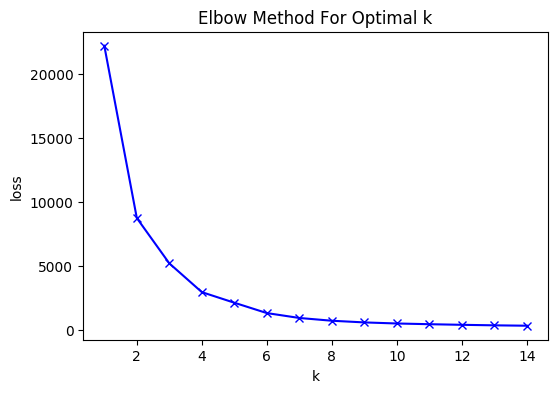

In [0]:
# import model
from sklearn.cluster import KMeans

# find out the optimal clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++')
    km = km.fit(df_train)
    Sum_of_squared_distances.append(km.inertia_)

# visualization
plt.style.use('default')
plt.figure(figsize = (6,4))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel("loss")
plt.title('Elbow Method For Optimal k')
plt.show()

Assumptions for finding best number of clusters: initial assumption for k is **three**. From the EDA for predicting win place of each player, we know that the player's winning percentile is most positively correlated with three types of statistics: killing stats, items acquired, and running distances. With this assumption in mind, we rely on statistical method of sum of squared distances to support our assumption as above. And we confirm that our proof of concept for optimal k is 3.

In [0]:
# train model
kmeans = KMeans(n_clusters=3, init = 'k-means++').fit(df_train)
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [0]:
# create cluster label to original dataset
data['cluster'] = kmeans.labels_

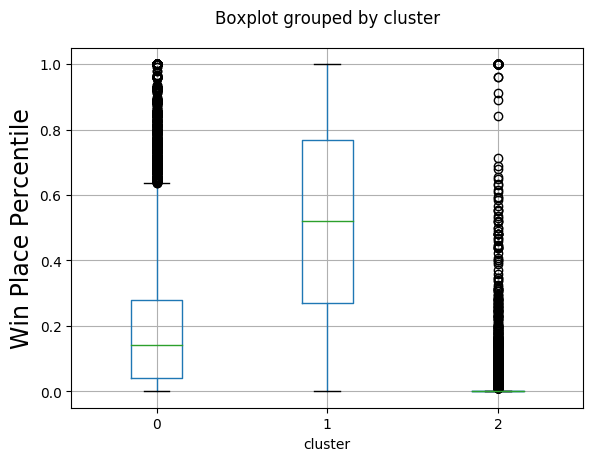

In [0]:
# win place
pd.DataFrame(data.loc[:,['cluster','winPlacePerc']]).boxplot(by='cluster')
plt.ylabel("Win Place Percentile", fontsize = 17)
plt.xlabel("cluster")
plt.title(" ")
plt.show()

From the above graph it appears that the three clusters of players could be categorized as three types, based on their winning statistics: **winner-winner** who has the best overall winning place, **good player** who has median overall winning place, and **learners** who has the least winning statistics. The following evaluation and analysis for these three groups help understand the segmentation of these three player clusters.

In [0]:
# rename label
data['cluster'] = np.where(data['cluster'] == 1, 'winner-winner', 
         (np.where(data['cluster'] == 0, 'good player', 'learner')))

In [0]:
def corrCluster(data, k):
  """
  Calculate and plot correlation, focusing on the winning place to figure out the variable that effects the winning place the most
  for each player group.
  args:
    data: DataFrame
    k: Str, cluster name
  """

  corr = data.groupby('cluster').get_group(k).loc[:,['winPlacePerc', 'headshotKills', 'killStreaks', 'longestKill', 'roadKills','rideDistance',
        'swimDistance','walkDistance', 'vehicleDestroys', 'weaponsAcquired', 'killsNorm', 'damageDealtNorm','assist_revives', 'boost_heals']].corr()
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
  plt.title("Heatmap correlation for {} group".format(k))
  plt.show()


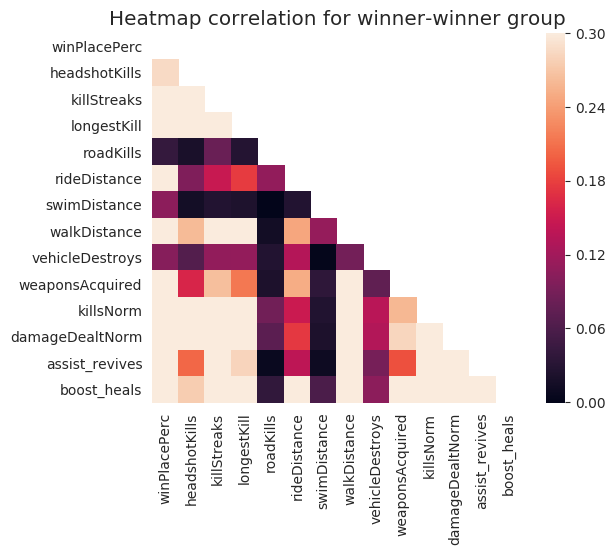

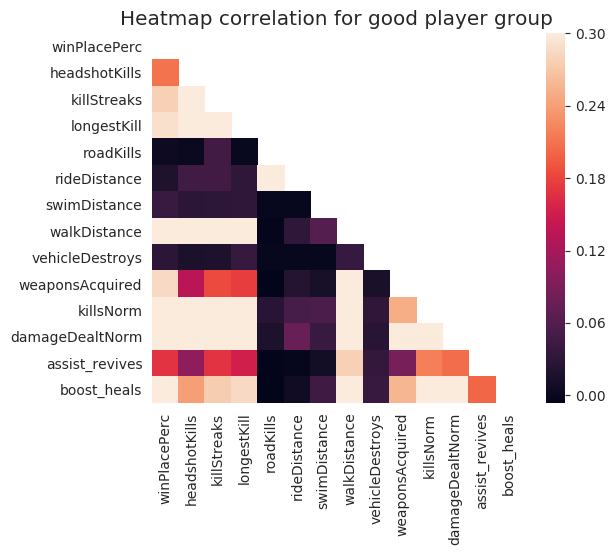

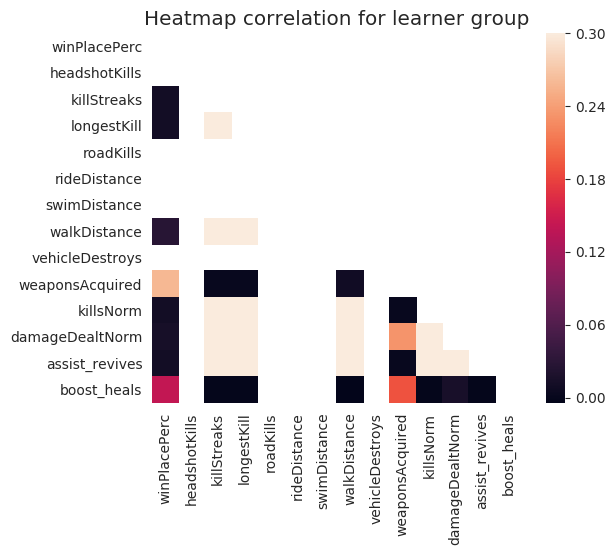

In [0]:
# plot corr
corrCluster(data,'winner-winner')
corrCluster(data, 'good player')
corrCluster(data, 'learner')

From the correlation heatmap, several initial insights could be drawn for the gaming strategy for each player cluster.  
1. Winner group relies the most on long moving distance, and has a generally good killing statistics.
2. Good players have a stronger correlation between killing statistics and winning place than that of the winner group, but not so strong for the moving distance. 
3. Learners have a strong correlation of resource collection such as weapons acquired and boost and heals. But they did not leverage them well because the correlation between killing statistics and winning place is not that strong for them.

With these in mind, here are the detailed differences in the distribution of critical statistics for each player group.

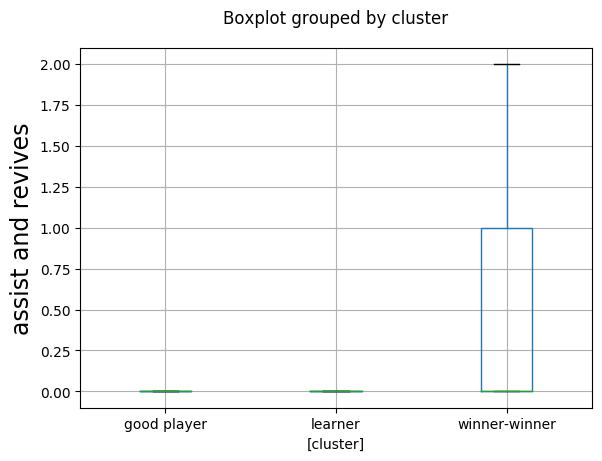

In [0]:
# assist revives
pd.DataFrame(data.loc[:,['cluster','assist_revives']]).boxplot(by='cluster', showfliers = False)
plt.title(" ")
plt.ylabel("assist and revives",fontsize = 17)
plt.show()

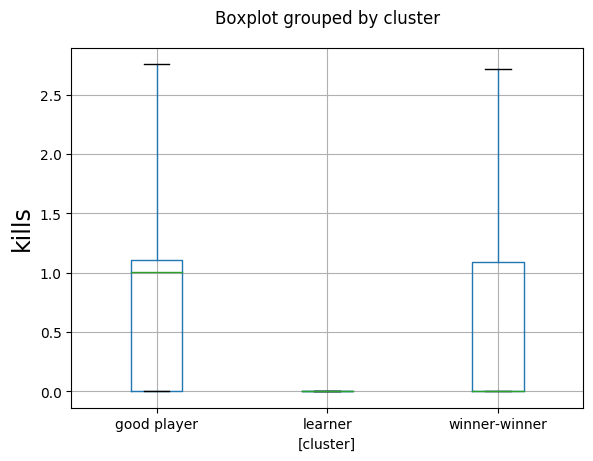

In [0]:
# kills
pd.DataFrame(data.loc[:,['cluster','killsNorm']]).boxplot(by='cluster',showfliers = False)
plt.title(" ")
plt.ylabel("kills", fontsize = 17)
plt.show()

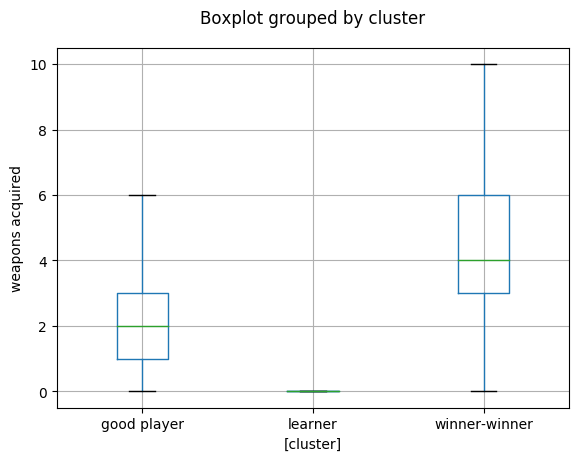

In [0]:
# weapon acquired
pd.DataFrame(data.loc[:,['cluster','weaponsAcquired']]).boxplot(by='cluster', showfliers = False)
plt.title(" ")
plt.ylabel("weapons acquired")
plt.show()

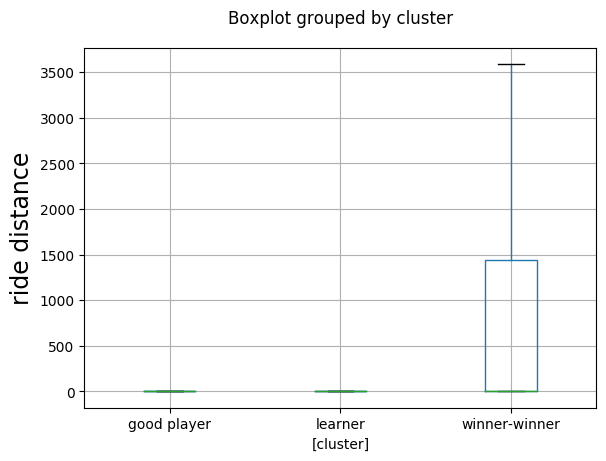

In [0]:
# riding distance
pd.DataFrame(data.loc[:,['cluster','rideDistance']]).boxplot(by='cluster', showfliers = False)
plt.title("")
plt.ylabel("ride distance", fontsize = 17)
plt.show()

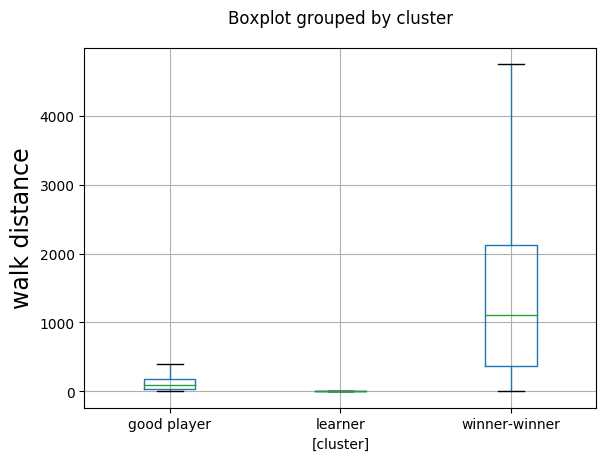

In [0]:
# walking distance
pd.DataFrame(data.loc[:,['cluster','walkDistance']]).boxplot(by='cluster', showfliers = False)
plt.title("")
plt.ylabel("walk distance", fontsize = 17)
plt.show()

### Conclusion
In conclusion, winners are not necessarily the best killer, but they are better team player than good players,  better driver than good players,
and a good marathon runner. The meaning for player segmentation is two-folded as on one hand it can help players understand the gaming strategy adopted by each group, ranked by their difference in winning place, and on the other hand it can help developers segment players and promote advertisement based on the behavior players adopted to enhance user engagement. For example, developers detect behaviors of players in matches and assign player groups to them. From there developers can send advertisement or emails targeting different player gropus. For more experienced players, emails focusing on positive reinforcement of their strategies and could send out free items that they normally use. For less experienced players, emails could focus on sending strategies of PUBG and some fun activities for them to explore more about this game style. The different promotion strategy targeting for different player groups could serve as a useful tool to increase user engagement.



## Anomaly Detection

In [0]:
# copy of data for AD
df = data

In [0]:
# distances to all clusters
alldistances = kmeans.fit_transform(df_train)
# distance to the closest cluster
totalDistance = np.min(alldistances, axis=1)

In [0]:
# create the distance from the closest cluster variable
df['distanceCluster'] = totalDistance

# get anomaly points where far from the cluster centroid by 0.1%
anomaly_fraction = 0.01 
number_of_anomalies = int(anomaly_fraction*len(df))
k = 4
anomalies_cluster = number_of_anomalies//k

lst_anomaly_index = list(df.sort_values(['cluster','distanceCluster'], ascending = False).groupby('cluster').head(anomalies_cluster).index)


In [0]:
# create anomaly label
dct_anomaly = {k:0 for k in range(totalDistance.shape[0])}
for i in lst_anomaly_index:
    dct_anomaly[i] = 1

df['anomaly'] = list(dct_anomaly.values())
# how many anomalies we captured
df.shape, df[(df.anomaly) == 1].shape  

((172833, 24), (1296, 24))

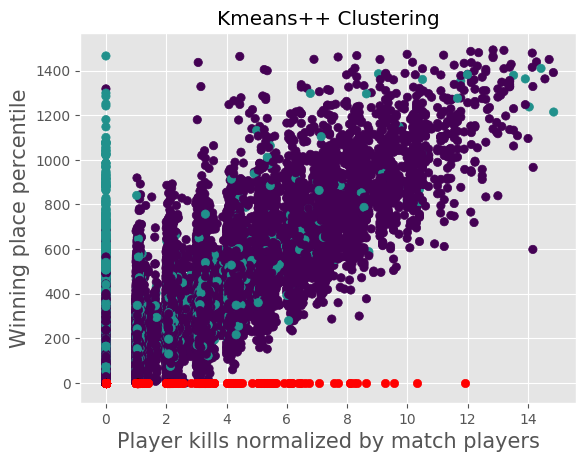

In [0]:
#Plot the clustering results based on 
# fig, ax = plt.subplots(figsize = (20,10))
anomaly_points = df[(df.anomaly) == 1]

scatter = plt.scatter(df.killsNorm, df.damageDealtNorm, c = kmeans.labels_)
anomaly = plt.scatter(anomaly_points.killsNorm, anomaly_points.winPlacePerc, c = 'red')

legend1 = ax.legend(*scatter.legend_elements(),
            loc="upper right", title="Clusters")

plt.xlabel("Player kills normalized by match players", fontsize = 15)
plt.ylabel("Winning place percentile", fontsize = 15)
plt.title("Kmeans++ Clustering")
plt.show()

In [0]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(df_train)
gmm_labels = gmm.predict(df_train)


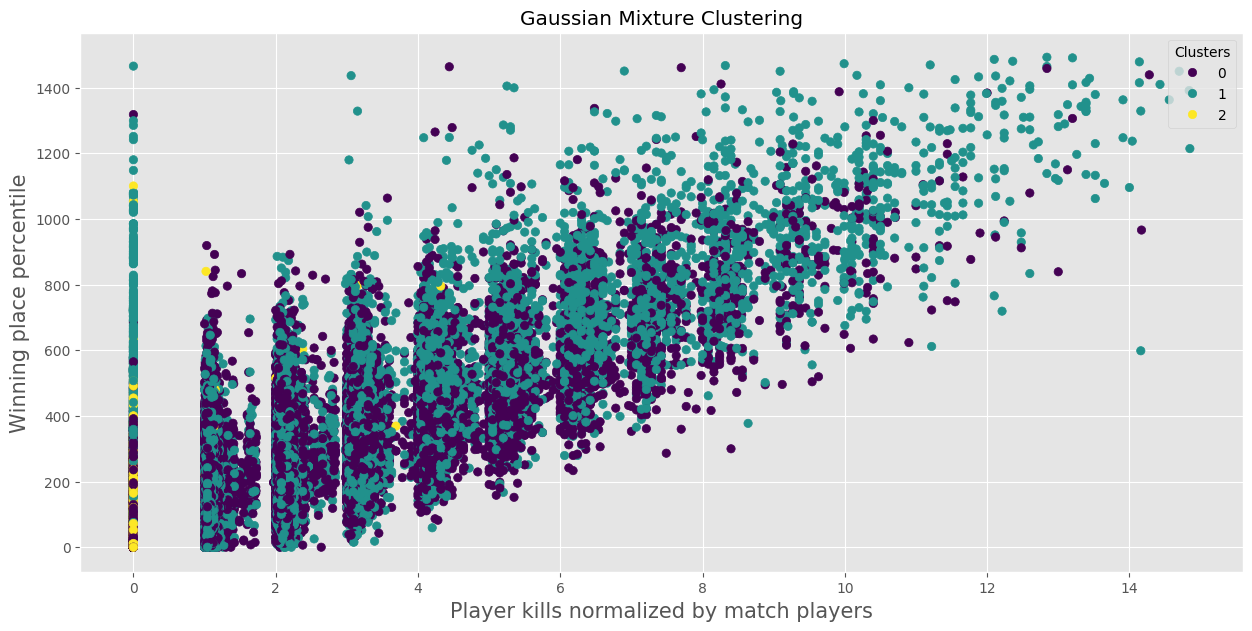

In [0]:
#Plot the clustering results based on 
fig, ax = plt.subplots(figsize = (15,7))
# anomaly_points = df[(df.anomaly) == 1]

scatter = plt.scatter(df.killsNorm, df.damageDealtNorm, c = gmm_labels)
# anomaly = plt.scatter(anomaly_points.killsNorm, anomaly_points.winPlacePerc, c = 'red')

legend1 = ax.legend(*scatter.legend_elements(),
            loc="upper right", title="Clusters")

plt.xlabel("Player kills normalized by match players", fontsize = 15)
plt.ylabel("Winning place percentile", fontsize = 15)
plt.title("Gaussian Mixture Clustering")
plt.show()

## APPENDIX

In [0]:
                #  ------------------ APPENDIX A: library import --------- #
# import library
import numpy as np
import pandas as pd
#### visualization
import matplotlib.pyplot as plt
import seaborn as sns
#### system
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(1234)
import time
import gc
#### scrapper
import requests
import json
import pandas
from pathlib import Path
import csv
#### ML
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [0]:
                        # ------------------ APPENDIX B: SCAPPER --------- #

# define api key
api_key = 'api_key'
# limit: 10 request per minute
api_key = Path(api_key).read_text().strip()

# define url
url = 'https://api.pubg.com/shards/'
# game platforms
platform_list = ['steam/','console/','kakao/']
# define headers
headers = {'Authorization': 'Bearer ' + api_key,
           'Accept': 'application/vnd.api+json'}

# get match samples
match_list = []
for platform in platform_list:
    sample_url = url + platform + 'samples'
    sample_response = requests.get(sample_url, headers=headers)
    sample_data = json.loads(sample_response.text)
    for match in sample_data['data']['relationships']['matches']['data']:
        match_list.append(match['id'])

# get all rows including all statistics needed
all_rows = []
for i,match in enumerate(match_list):
    match_url = url + platform + 'matches/' + match
    match_response = requests.get(match_url, headers = headers)
    # get match
    sample_match = json.loads(match_response.text)
    # get match attributes
    matchType = sample_match['data']['attributes']['gameMode']
    matchDuration = sample_match['data']['attributes']['duration']
    matchId = match
    # get player attributes
    included = sample_match['included']
    for obj in included:
        if obj['type'] == 'participant':
            player = obj['attributes']['stats']
            playerId = player['playerId']
            playerName = player['name']
            DBNOs = player['DBNOs']
            assists = player['assists']
            boosts = player['boosts']
            damageDealt = player['damageDealt']
            deathType = player['deathType']
            headshotKills = player['headshotKills']
            heals = player['heals']
            killPlace = player['killPlace']
            killStreaks = player['killStreaks']
            kills = player['kills']
            longestKill = player['longestKill']
            revives = player['revives']
            rideDistance = player['rideDistance']
            roadKills = player['roadKills']
            swimDistance = player['swimDistance']
            teamKills = player['teamKills']
            timeSurvived = player['timeSurvived']
            vehicleDestroys = player['vehicleDestroys']
            walkDistance = player['walkDistance']
            weaponsAcquired = player['weaponsAcquired']
            winPlace = player['winPlace']
            row = (playerId, matchId, assists, boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,
                   kills,killStreaks,longestKill,matchDuration,matchType,revives,
                   rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlace)
            all_rows.append(row)

# to csv
columns = ["playerId", "matchId", "assists", "boosts","damageDealt","DBNOs","headshotKills","heals","killPlace","kills","killStreaks","longestKill","matchDuration","matchType","revives","rideDistance","roadKills","swimDistance","teamKills","vehicleDestroys","walkDistance","weaponsAcquired","winPlace"]
import csv
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(columns)
    for row in all_rows:
        writer.writerow(row)


APPENDIX B Continued: 
data introduction

playerId - Integer ID to identify a player.   
matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.   
assists - Number of enemy players this player damaged that were killed by teammates.   
boosts - Number of boost items used.   
damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.   
DBNOs - Number of enemy players knocked.   
headshotKills - Number of enemy players killed with headshots.   
heals - Number of healing items used.   
killPlace - Ranking in match of number of enemy players killed.   
killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) .  
kills - Number of enemy players killed.   
killStreaks - Max number of enemy players killed in a short amount of time.   
longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.   
matchDuration - How long a match takes.  
matchType - Type of a match: squad, duo, solo, squad-fpp, duo-fpp, solo-fpp.   
revives - Number of times this player revived teammates.   
rideDistance - Total distance traveled in vehicles measured in meters.   
roadKills - Number of kills while in a vehicle.   
swimDistance - Total distance traveled by swimming measured in meters.   
teamKills - Number of times this player killed a teammate.   
vehicleDestroys - Number of vehicles destroyed.    
walkDistance - Total distance traveled on foot measured in meters.    
weaponsAcquired - Number of weapons picked up.   
winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) .   
winPlace - The final ranking in a match.    

In [0]:
              # ----------- APPENDIX C: FEATURE ENGINEERING for outliers detection------------- #
def outlierFeatureEngineering(df):

  # player statistics are by match level. So we normalize the statistics by the number of players jonied.
  df['playersJoined'] = df.groupby("matchId")['playerId'].transform(len)

  # normalize feature winPlacePerc for the winning place by players joined for each match
  df['winPlacePerc'] = df.groupby(df['matchId'])['winPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
  df['winPlacePerc'].fillna(0,inplace = True)

  # normalize selected killing statistics by players joined for each match
  df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
  df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)

  # combine distances together and cerate feature totalDistance
  df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

  # create headshot_rate feature
  df['headshot_rate'] = df['headshotKills'] / df['kills']
  df['headshot_rate'] = df['headshot_rate'].fillna(0)

  # create label assist and revives
  df['assist_revives'] = df['assists'] + df['revives']

  # create label boosts and heals
  df['boost_heals'] = df['boosts'] + df['heals']

  # drop unuseful columns
  df = df.drop(columns = ['winPlace','kills','teamKills','damageDealt','DBNOs','killPlace','revives','assists','boosts','heals'])

  return df

